Restaurant data for slalom AI for All challenge

Given the data sets from the slalom team, analyzie and figure out a model to predict revenue vs location

Notes:
our "client" provides a drive-thru experience, with some mobile ordering.

I already checked the main named columns with openrefine- i found no NaN's or other problems

In [71]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


In [72]:
train = pd.read_csv('./train_data.csv')
test_df = pd.read_csv('./test_data.csv')
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,4244605.96
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,3287351.70
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,4219403.66
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,3.0,0,4,0,0,0,0,0,0,3937158.64
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,5877728.96


In [73]:
train.shape

(99710, 43)

In [74]:
test_df.shape

(137, 42)

start with some descriptions of the training data...

First have a go at the numeric columns (the so called "PX" columns), which we have very little data on.  And a quick ccheck to make sure i did not miss something in my 'openrefine' efforts.

In [75]:
train.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,...,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,9.971000e+04
mean,50002.992980,4.093762,4.431978,4.215766,4.398501,1.991385,2.878799,5.301083,4.931140,5.252161,...,3.088948,2.087103,1.195076,1.946023,0.988888,2.111303,1.834741,1.971758,0.975058,4.809134e+06
std,28869.067522,2.813350,1.426747,0.842940,1.035292,1.065730,1.530582,2.180389,1.720239,1.704360,...,1.781155,4.313285,2.308883,3.974532,1.535414,4.686425,3.229393,3.807489,1.678317,1.197243e+06
min,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.881144e+06
25%,25000.250000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.089145e+06
50%,50004.500000,3.000000,5.000000,4.000000,4.000000,2.000000,2.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.709871e+06
75%,75002.750000,4.000000,5.000000,4.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.419663e+06
max,99999.000000,15.000000,7.500000,6.000000,7.500000,6.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,25.000000,15.000000,25.000000,6.000000,30.000000,15.000000,20.000000,8.000000,1.284582e+07


In [76]:
train.isnull().sum().sort_index()/len(train)

City          0.0
City Group    0.0
Id            0.0
Open Date     0.0
P1            0.0
P10           0.0
P11           0.0
P12           0.0
P13           0.0
P14           0.0
P15           0.0
P16           0.0
P17           0.0
P18           0.0
P19           0.0
P2            0.0
P20           0.0
P21           0.0
P22           0.0
P23           0.0
P24           0.0
P25           0.0
P26           0.0
P27           0.0
P28           0.0
P29           0.0
P3            0.0
P30           0.0
P31           0.0
P32           0.0
P33           0.0
P34           0.0
P35           0.0
P36           0.0
P37           0.0
P4            0.0
P5            0.0
P6            0.0
P7            0.0
P8            0.0
P9            0.0
Type          0.0
revenue       0.0
dtype: float64

Now some simple diagrams.

Let's check to see what types of restaurants are in the training data set.  
Note:
DT = "Drive thru", 
IL = "in line"
FC = "Food Court"
MB = "Mobile"

We see from the next diagram that there are no "Mobile" restaurants.  Food court and inline dominate.

As far as "City Group" = just about the same number  of "big city" as "other"

/Users/muguira/code/stocks/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/var/folders/c8/72_459cs1d7d0dywsflw6ctm0000gn/T/ipykernel_31347/2915874856.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


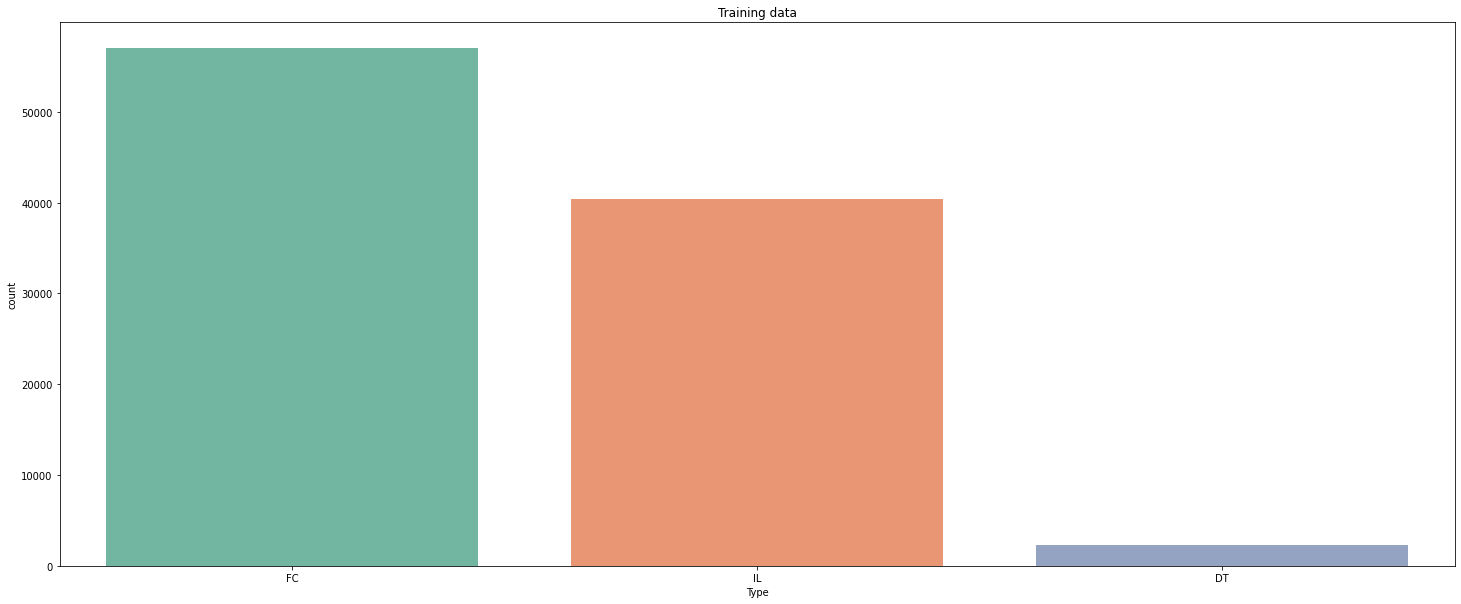

In [77]:
fig, ax = plt.subplots(figsize=(25,10))
g1 = sns.countplot(train['Type'],palette="Set2");
ax.set_title("Training data")
fig.show()

/Users/muguira/code/stocks/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/var/folders/c8/72_459cs1d7d0dywsflw6ctm0000gn/T/ipykernel_31347/3931942769.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


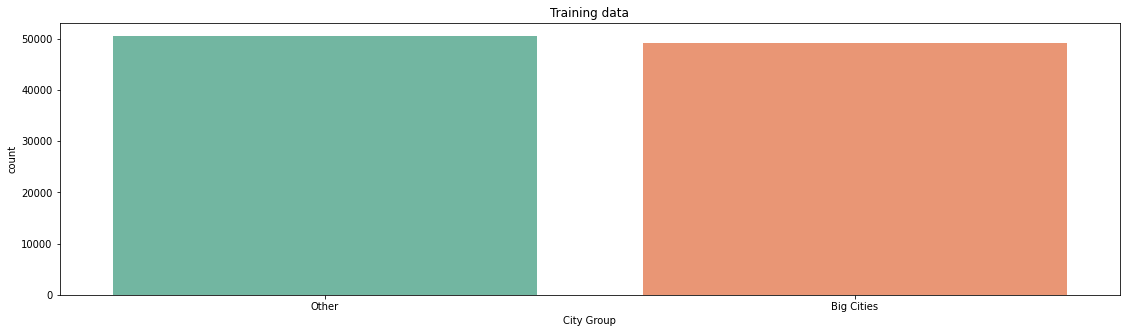

In [78]:
fig, ax = plt.subplots(figsize=(19,5))
g1 = sns.countplot(train['City Group'],palette="Set2");
ax.set_title("Training data")
fig.show()

Interesting,  ...

There are cities in the training set that are not in the test 


In [79]:
(train['City'].nunique(), test_df['City'].nunique())

(57, 34)

Let's find  the earliest and latest Open Date for the training data.

We will use this later to sort the restaurants by how long  they have been open

In [82]:
train['Date'] = pd.to_datetime(train['Open Date'])

In [88]:
(max(train['Date']), min(train['Date']))

(Timestamp('2014-01-04 00:00:00'), Timestamp('1995-05-08 00:00:00'))

=========================================================
Ok, i am not going to tackle the "PX" columns right now...

=========================================================

Let's have a go on the revenue column...

First, create a histogram and check for skew and distribution...

Visual inspection reveals a little skew to  the right (notice the tail out to the right from the black line).  Linear prediction models like to be feed  nice "normally" distributed data.  

The probability plot of  the training data should create a straight line.  as you can see there are some issues at  the ends. The curve looks a little like a "C", showing the Right Skew of  the data

Bottom line:
We'll have to do some transformations on the revenue.

/Users/muguira/code/stocks/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/var/folders/c8/72_459cs1d7d0dywsflw6ctm0000gn/T/ipykernel_31347/2343893791.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show();


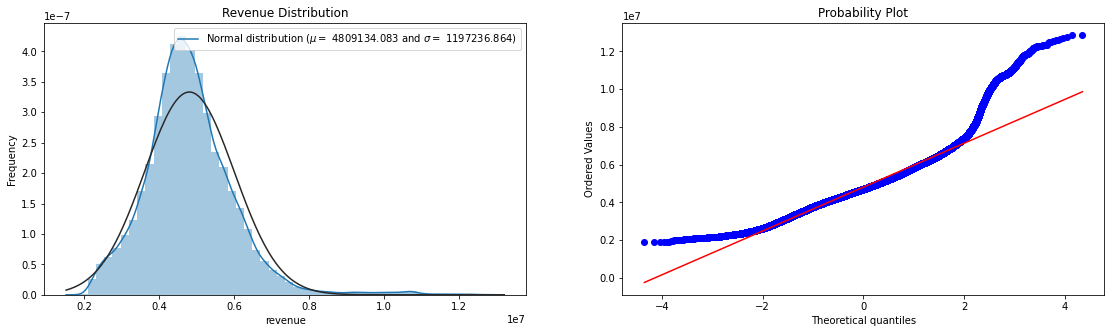

In [90]:
# first compare the distrubtion, to check for any skew

(mu, sigma) = norm.fit(train['revenue'])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(train['revenue'] , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Revenue Distribution')
ax2 = stats.probplot(train['revenue'], plot=plt)
f.show();
